In [1]:

import argparse
import math
import os
import random
from pdb import set_trace
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from decimal import Decimal

random.seed(40579)

OUTPUT_DIRECTORY = "output"


class Config:
    T = 1000  # time (1000)
    N = 10000  # number of firms
    Ñ = 180  # size parameter

    c = 1  # parameter bankruptcy cost equation
    α = Decimal("0.08")  # alpha, ratio equity-loan
    g = Decimal("1.1")  # variable cost
    ω = Decimal("0.002")  # markdown interest rate (the higher it is, the monopolistic power of banks)
    λ = Decimal("0.3")  # credit assets rate
    d = 100  # location cost
    e = Decimal("0.1")  # sensitivity

    # firms initial parameters
    K_i0 = Decimal("100")  # capital
    A_i0 = Decimal("20")  # asset
    L_i0 = Decimal("80")  # liability
    π_i0 = Decimal("0")  # profit
    B_i0 = Decimal("0")  # bad debt
    φ_i0 = Decimal("0.1") # initial phi
    # risk coefficient for bank sector (Basel)
    v = Decimal("0.2")

    delta1 = 0.001
    delta2 = 0.002

    coef_zeta = Decimal("0.004")
    add_new_firms = True

    sigma = Decimal("0.02")  # 0.02-0.05
    beta = 2  # bernoulli

In [2]:
class Statistics:
    doLog = False
    logfile = None

    def enableLog(logfile: str = None):
        if logfile:
            Statistics.logfile = open(OUTPUT_DIRECTORY + "/" + logfile, 'w', encoding="utf-8")
        Statistics.doLog = True

    def log(cadena):
        if Statistics.doLog:
            if Statistics.logfile:
                Statistics.logfile.write(cadena + "\n")
            else:
                print(cadena)

    firms = []
    bankSector = []

    bankruptcy = []
    firmsK = []
    firmsπ = []
    firmsL = []
    firmsB = []
    firmsNum = []
    newFirms = []
    rate = []
    firmsz = []
    firmsmu = []
    firmsY = []
    firmsφ = []

    @staticmethod
    def getStatistics():
        Statistics.log("t=%4s [firms] n=%s,sumA=%.2f,sumL=%.2f,sumK=%.2f,sumπ=%2.f" % (Status.t, len(Status.firms),
                                                                                       Status.firmsAsum,
                                                                                       Status.firmsLsum,
                                                                                       Status.firmsKsum,
                                                                                       Status.firmsπsum))
        Statistics.log("       [bank]  avgRate=%.2f,D=%.2f,L=%.2f,E=%0.2f,B=%.2f,π=%.2f" % (BankSector.getAverageRate(),
                                                                                            BankSector.D, BankSector.L,
                                                                                            BankSector.E,
                                                                                            BankSector.B, BankSector.π))
        Statistics.firmsK.append(Status.firmsKsum)
        Statistics.firmsπ.append(Status.firmsπsum)
        Statistics.firmsL.append(Status.firmsLsum)
        Statistics.firmsB.append(BankSector.B)
        Statistics.firmsNum.append(len(Status.firms))
        Statistics.rate.append(BankSector.getAverageRate())
        Statistics.firmsY.append(Status.firmsYsum)
        Statistics.firmsφ.append(Status.firmsφsum)
        mu = 0
        zeta = []
        for i in Status.firms:
            mu += i.mu
            zeta.append(i.zeta)
        Statistics.firmsz.append(zeta)
        Statistics.firmsmu.append(mu)


class Status:
    firms = []
    firmsKsum = Decimal("0.0")
    firmsAsum = Decimal("0.0")
    firmsLsum = Decimal("0.0")
    firmsπsum = Decimal("0.0")
    firmsAsum = Decimal("0.0")
    firmsφsum = Decimal("0.0")

    numFailuresGlobal = 0
    t = 0

    firmsKsums = []
    firmsGrowRate = []

    firmIdMax = 0

    @staticmethod
    def getNewFirmId():
        Status.firmIdMax += 1
        return Status.firmIdMax

    @staticmethod
    def initialize():
        for i in range(Config.N):
            Status.firms.append(Firm())


class Firm():
    K = Config.K_i0  # capital
    A = Config.A_i0  # asset
    r = Decimal("0.0")  # rate money is given by banksector
    L = Config.L_i0  # credit
    π = Decimal("0.0")  # profit
    u = Decimal("0.0")

    φ = Config.φ_i0  # initial capital productivity
    mu = Decimal("0.0")
    zeta = Decimal("0.0")
    innovation = Decimal("0.0")

    def __init__(self):
        self.id = Status.getNewFirmId()

    def determineCredit(self):
        # (equation 11)
        result = Config.λ * BankSector.L * self.K / Status.firmsKsum + (
                1 - Config.λ) * BankSector.L * self.A / Status.firmsAsum
        ## Statistics.log( "a*%s*%s/%s+(1-a)*%s*%s/%s  L=%s" % (BankSector.L,self.K,Status.firmsKsum,BankSector.L,self.A,Status.firmsAsum,result))
        return result

    def determineInterestRate(self):
        # (equation 12)
        return (2 + self.A) / (2 * Config.c * Config.g * (1 / (Config.c * self.φ) + self.π + self.A) +
                               2 * Config.c * Config.g * BankSector.L * (
                                       Config.λ * self.__ratioK() + (1 - Config.λ) * self.__ratioA()))

    def __ratioK(self):
        return self.K / Status.firmsKsum

    def __ratioA(self):
        return self.A / Status.firmsAsum

    def determineCapital(self):
        # equation 9
        return (self.φ - Config.g * self.r) / (Config.c * self.φ * Config.g * self.r) + (
                self.A / (2 * Config.g * self.r))

    def determineU(self):
        return Decimal(str(random.random())) * 2

    def determineAssets(self):
        # equation 6
        return self.A + self.π  # K - self.L

    def determineProfit(self):
        # equation 5
        result = (self.u * self.φ - Config.g * self.r) * self.K
        if result > 0:
            self.innovation = Config.sigma * result
            self.mu = self.innovation / self.K
            self.zeta = 1 - math.exp(-Config.beta * self.mu)
            result -= (Config.sigma * result)
        # Statistics.log("%s = %s * %s -  %s * %s / %s" % (result,self.u,self.φ,Config.g,self.r,self.K))
        return result

    def determineφ(self):
        if self.zeta > Config.coef_zeta:
            self.φ = self.φ * (1 + Decimal(str(random.uniform(Config.delta1, Config.delta2))))
        else:
            self.φ = self.φ
        return self.φ


class BankSector():
    E = Config.N * Config.L_i0 * Config.v
    B = Config.B_i0  # bad debt
    D = Decimal("0")
    π = Decimal("0")

    @staticmethod
    def determineDeposits():
        # as a residual from L = E+D, ergo D=L-E
        return BankSector.L - BankSector.E

    @staticmethod
    def determineProfit():
        # equation 13
        profitDeposits = Decimal("0.0")
        for firm in Status.firms:
            profitDeposits += firm.r * firm.L
        BankSector.D = BankSector.determineDeposits()
        return profitDeposits - BankSector.getAverageRate() * ((1 - Config.ω) * BankSector.D + BankSector.E)

    @staticmethod
    def getAverageRate():
        average = Decimal("0.0")
        for firm in Status.firms:
            average += firm.r
        return average / len(Status.firms)

    @staticmethod
    def determineEquity():
        # equation 14
        result = BankSector.π + BankSector.E - BankSector.B
        # Statistics.log("  bank E %s =%s + %s - %s" % (result,BankSector.π , BankSector.E , BankSector.B))
        return result


def removeBankruptedFirms():
    i = 0
    BankSector.B = Decimal("0.0")
    for firm in Status.firms[:]:
        if (firm.π + firm.A) < 0:
            ##Statistics.log("quiebra %d %s %s" % (firm.id,firm.π,firm.A))
            # bankrupt: we sum Bn-1
            ##Statistics.log( "    %s+%s<0 y  %s-%s=%s" % (firm.π,firm.A,firm.L,firm.K,(firm.L-firm.K)))
            BankSector.B += (firm.L - firm.K)  # **********************************
            Status.firms.remove(firm)
            Status.numFailuresGlobal += 1
            i += 1
    Statistics.log("        - removed %d firms %s" % (i, "" if i == 0 else " (next step B=%s)" % BankSector.B))
    Statistics.bankruptcy.append(i)
    return i


def addFirms(Nentry):
    for i in range(Nentry):
        Status.firms.append(Firm())
    Statistics.log("        - add %d new firms (Nentry)" % Nentry)


def updateFirmsStatus():
    Status.firmsAsum = Decimal("0.0")
    Status.firmsKsum = Decimal("0.0")
    Status.firmsLsum = Decimal("0.0")
    Status.firmsYsum = Decimal("0.0")
    Status.firmsφsum = Decimal("0.0")
    for firm in Status.firms:
        Status.firmsAsum += firm.A
        Status.firmsKsum += firm.K
        Status.firmsLsum += firm.L
        Status.firmsYsum += firm.K * firm.φ
        Status.firmsφsum += firm.φ

    Status.firmsKsums.append(Status.firmsKsum)
    Status.firmsGrowRate.append(
        0 if Status.t == 0 else (Status.firmsKsums[Status.t] - Status.firmsKsums[Status.t - 1]) / Status.firmsKsums[
            Status.t - 1])


def updateFirms():
    totalK = Decimal("0.0")
    totalL = Decimal("0.0")
    Status.firmsπsum = Decimal("0.0")
    for firm in Status.firms:
        firm.L = firm.determineCredit()
        totalL += firm.L
        firm.r = firm.determineInterestRate()
        kantes = firm.K
        firm.K = firm.determineCapital()
        # Statistics.log("firm%d. K=%f > K=%f" % (firm.id, kantes, firm.K))

        totalK += firm.K
        firm.u = firm.determineU()
        firm.π = firm.determineProfit()
        firm.determineφ()
        firm.A = firm.determineAssets()
        Status.firmsπsum += firm.π
    # update Kt-1 and At-1 (Status.firmsKsum && Status.firmsAsum):
    updateFirmsStatus()
    # Statistics.log("  K:%s L:%s pi:%s" % (totalK,totalL,Status.firmsπsum) )
    # code.interact(local=locals())


def determineNentry():
    # equation 15
    return round(Config.Ñ / (1 + math.exp(Config.d * (BankSector.getAverageRate() - Config.e))))


def updateBankL():
    BankSector.L = BankSector.E / Config.v


def updateBankSector():
    BankSector.π = BankSector.determineProfit()
    BankSector.E = BankSector.determineEquity()
    BankSector.D = BankSector.L - BankSector.E

In [3]:
def doSimulation(doDebug=False):
    Status.initialize()
    updateFirmsStatus()
    updateBankL()
    BankSector.D = BankSector.L - BankSector.E
    for t in range(Config.T):
        Status.t = t
        Statistics.getStatistics()
        removeBankruptedFirms()
        newFirmsNumber = determineNentry()
        Statistics.newFirms.append(newFirmsNumber)
        addFirms(newFirmsNumber)
        updateBankL()
        updateFirms()
        updateBankSector()

        if doDebug and (doDebug == t or doDebug == -1):
            set_trace()


def plot_newentry(show=True):
    Statistics.log("newentry")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append(Statistics.newFirms[i])
        addFirms(yy[-1])
    plt.plot(xx, yy, 'b-')
    plt.ylabel("New Entries")
    plt.xlabel("t")
    plt.title("New Entries")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/newentry.svg")


def plot_zipf_density(show=True):
    Statistics.log("zipf_density")
    plt.clf()
    zipf = {}  # log K = freq
    for firm in Status.firms:
        if round(firm.K) > 0:
            x = math.log(round(firm.K))
            if x in zipf:
                zipf[x] += 1
            else:
                zipf[x] = 1
    x = []
    y = []
    for i in zipf:
        x.append(i)
        y.append(math.log(zipf[i]))
    plt.plot(x, y, 'o', color="blue")
    plt.ylabel("log freq")
    plt.xlabel("log K")
    plt.title("Zipf plot of firm sizes")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/zipf_density.svg")

In [4]:
def plot_zipf_density1(show=True):
    Statistics.log("zipf_density")
    plt.clf()
    zipf = {}  # log K = freq
    for firm in Status.firms:
        if round(firm.K) > 0:
            x = math.log(round(firm.K))
            if x in zipf:
                zipf[x] += 1
            else:
                zipf[x] = 1
    x = []
    y = []
    for i in zipf:
        if math.log(zipf[i]) >= 1:
            x.append(i)
            y.append(math.log(zipf[i]))
    plt.plot(x, y, 'o', color="blue")
    plt.ylabel("log freq")
    plt.xlabel("log K")
    plt.title("Zipf plot of firm sizes (modified)")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/zipf_density1.svg")


def plot_zipf_rank(show=True):
    Statistics.log("zipf_rank")
    plt.clf()
    y = []  # log K = freq
    x = []
    for firm in Status.firms:
        if round(firm.K) > 0:
            y.append(math.log(firm.K))
    y.sort();
    y.reverse()
    for i in range(len(y)):
        x.append(math.log(float(i + 1)))
    plt.plot(y, x, 'o', color="blue")
    plt.xlabel("log K")
    plt.ylabel("log rank")
    plt.title("Rank of K (zipf)")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/zipf_rank.svg")


def plot_aggregate_output(show=True):
    Statistics.log("aggregate_output")
    plt.clf()
    xx1 = []
    yy = []
    for i in range(150, Config.T):
        yy.append(i)
        xx1.append(math.log(Status.firmsKsums[i]))
    plt.plot(yy, xx1, 'b-')
    plt.ylabel("ln Y")
    plt.xlabel("t")
    plt.title("Logarithm of aggregate output")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/aggregate_output.svg")


def plot_profits(show=True):
    Statistics.log("profits")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
        xx.append(i)
        yy.append(Statistics.firmsπ[i] / Statistics.firmsNum[i])
    plt.plot(xx, yy, 'b-')
    plt.ylabel("avg profits")
    plt.xlabel("t")
    plt.title("profits of companies")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/profits.svg")


def plot_baddebt(show=True):
    Statistics.log("bad_debt")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
        xx.append(i)
        yy.append(-Statistics.firmsB[i] / Statistics.firmsNum[i])
    plt.plot(xx, yy, 'b-')
    plt.ylabel("avg bad debt")
    plt.xlabel("t")
    plt.title("Bad debt")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/bad_debt_avg.svg")


def plot_bankrupcies(show=True):
    Statistics.log("bankrupcies")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
        xx.append(i)
        yy.append(Statistics.bankruptcy[i])
    plt.plot(xx, yy, 'b-')
    plt.ylabel("num of bankrupcies")
    plt.xlabel("t")
    plt.title("Bankrupted firms")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/bankrupted.svg")


def plot_bad_debt(show=True):
    Statistics.log("bad_debt")
    plt.clf()
    xx = []
    yy = []
    for i in range(150, Config.T):
        if Statistics.firmsB[i] < 0:
            xx.append(i)
            yy.append(math.log(-Statistics.firmsB[i]))
    plt.plot(xx, yy, 'b-')
    plt.ylabel("ln B")
    plt.xlabel("t")
    plt.title("Bad debt")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/bad_debt.svg")


def plot_interest_rate(show):
    Statistics.log("interest_rate")
    plt.clf()
    xx2 = []
    yy = []
    for i in range(150, Config.T):
        yy.append(i)
        xx2.append(Statistics.rate[i])
    plt.plot(yy, xx2, 'b-')
    plt.ylabel("mean rate")
    plt.xlabel("t")
    plt.title("Mean interest rates of companies")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/interest_rate.svg")


def plot_growth_rate(show):
    Statistics.log("growth_rate")
    plt.clf()
    xx2 = []
    yy = []
    for i in range(150, Config.T):
        if Status.firmsGrowRate[i] != 0:
            yy.append(i)
            xx2.append(Status.firmsGrowRate[i])
    plt.plot(yy, xx2, 'b-')
    plt.ylabel("growth")
    plt.xlabel("t")
    plt.title("Growth rates of agg output")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/growth_rates.svg")


def plot_zeta(show=True):
    Statistics.log("zeta")
    plt.clf()
    for i in range(len(Statistics.firmsz)):
        plt.plot([i] * len(Statistics.firmsz[i]), Statistics.firmsz[i], 'b.', alpha=0.3)
    plt.title("Zeta Values for All Firms over Time")
    plt.xlabel("Time")
    plt.ylabel("Zeta Value")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/zeta.svg")


def plot_y(show):
    Statistics.log("y")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append(math.log(Statistics.firmsY[i]))
    plt.plot(xx, yy, 'b-')
    plt.ylabel("ln Y")
    plt.xlabel("t")
    plt.title("Y")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/y.svg")


def plot_phi(show=True):
    Statistics.log("")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append(Statistics.firmsφ[i] / Statistics.firmsNum[i])
    plt.plot(xx, yy, 'b-')
    plt.ylabel("Phi")
    plt.xlabel("t")
    plt.title("Phi")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/phi.svg")


def plot_k(show):
    Statistics.log("k")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append( math.log( Statistics.firmsK[i]) )
    plt.plot(xx, yy, 'b-')
    plt.ylabel("ln K")
    plt.xlabel("t")
    plt.title("K")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/k.svg")


def plot_qq_firms_k(show):
    plt.clf()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    sm.qqplot(
        np.log(pd.DataFrame(Statistics.firmsK, columns=['K'])),
        fit=True,
        line='q',
        alpha=0.4,
        lw=2,
        ax=ax
    )
    ax.set_title('Chart Q-Q log(firmsK)', fontsize=13)
    ax.tick_params(labelsize=7)
    shapiro_test = stats.shapiro(np.log(pd.DataFrame(Statistics.firmsK, columns=['K'])))
    if is_notebook():
        print(f"Variable height: {shapiro_test}")
    correlation = pd.DataFrame(zip(Statistics.firmsK, Statistics.firmsL), columns=['K', 'L'])
    if is_notebook():
        print('Coef Pearson:\n', correlation.corr(method='pearson'))
        print('\nCoef Spearman:\n', correlation.corr(method='spearman'))
        print('\nCoef Kendall:\n', correlation.corr(method='kendall'))
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/qq_firmsk.svg")


def plot_qq(show):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sm.qqplot(
        pd.DataFrame(Statistics.firmsK, columns=['K']),
        fit=True,
        line='q',
        alpha=0.4,
        lw=2,
        ax=axs[0]
    )
    axs[0].set_title('Chart Q-Q firmsK', fontsize=10, fontweight="bold")
    axs[0].tick_params(labelsize=7)
    sm.qqplot(
        pd.DataFrame(Statistics.bankruptcy, columns=['Bankrupcies']),
        fit=True,
        line='q',
        alpha=0.4,
        lw=2,
        ax=axs[1]
    )
    axs[1].set_title('Chart Q-Q Bankruptcies', fontsize=10, fontweight="bold")
    axs[1].tick_params(labelsize=7)
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/qq.svg")


def plot_distribution_kl(show):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    axs[0].hist(x=Statistics.firmsK, bins=20, color="#3182bd", alpha=0.5)
    axs[0].plot(Statistics.firmsK, np.full_like(Statistics.firmsK, -0.01), '|k', markeredgewidth=1)
    axs[0].set_title('FirmsK distribution')
    axs[0].set_xlabel('FirmsK')
    axs[0].set_ylabel('counts')

    axs[1].hist(x=Statistics.firmsπ, bins=20, color="#3182bd", alpha=0.5)
    axs[1].plot(Statistics.firmsπ, np.full_like(Statistics.firmsπ, -0.01), '|k', markeredgewidth=1)
    axs[1].set_title('FirmsL distribution')
    axs[1].set_xlabel('FirmsL')
    axs[1].set_ylabel('counts')

    plt.tight_layout()
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/distribution.svg")


def plot_mu(show=True):
    Statistics.log("mu")
    plt.clf()
    xx = []
    yy = []
    for i in range(Config.T):
        xx.append(i)
        yy.append(Statistics.firmsmu[i] / Config.N)
    plt.plot(xx, yy, 'b-')
    plt.ylabel("Mu")
    plt.xlabel("t")
    plt.title("Mu")
    plt.show() if show else plt.savefig(OUTPUT_DIRECTORY + "/mu.svg")


def show_figures(show):
    plot_aggregate_output(show)
    plot_growth_rate(show)
    plot_zipf_rank(show)
    plot_zipf_density(show)
    plot_zipf_density1(show)
    plot_profits(show)
    plot_bad_debt(show)
    plot_baddebt(show)
    plot_bankrupcies(show)
    plot_interest_rate(show)
    # plot_qq_firms_k(show)
    # plot_qq(show)
    # plot_distribution_kl(show)
    plot_y(show)
    plot_phi(show)
    plot_zeta(show)
    plot_mu(show)
    plot_k(show)
    plot_newentry(show)

In [5]:

def doInteractive():
    parser = argparse.ArgumentParser(description="Fluctuations firms/banks")
    parser.add_argument("--plot", action="store_true", help="Shows the plots")
    parser.add_argument("--sizeparam", type=int, help="Size parameter (default=%s)" % Config.Ñ)
    parser.add_argument("--saveplot", action="store_true", help="Save the plots in dir '" + OUTPUT_DIRECTORY + "'")
    parser.add_argument("--log", action="store_true", help="Log (stdout default)")
    parser.add_argument("--logfile", type=str, help="Log to file in directory '" + OUTPUT_DIRECTORY + "'")
    parser.add_argument("--debug", help="Do a debug session at t=X, default each t", type=int, const=-1, nargs='?')
    args = parser.parse_args()

    if args.sizeparam:
        Config.Ñ = int(args.sizeparam)
        if Config.Ñ < 0 or Config.Ñ > Config.N:
            print("value not valid for Ñ: must be 0..%s" % Config.N)

    if args.log or args.logfile:
        Statistics.enableLog(args.logfile)

    doSimulation(args.debug)
    if Status.numFailuresGlobal > 0:
        Statistics.log("[total failures in all times = %s " % Status.numFailuresGlobal)
    else:
        Statistics.log("[no failures]")
    if args.plot:
        show_figures(True)
    if args.saveplot:
        show_figures(False)


def is_notebook():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False

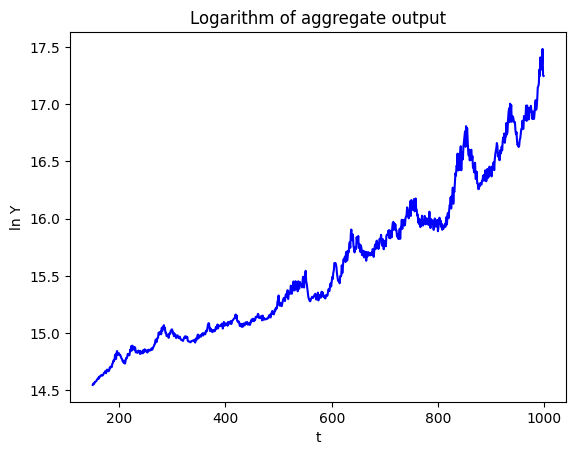

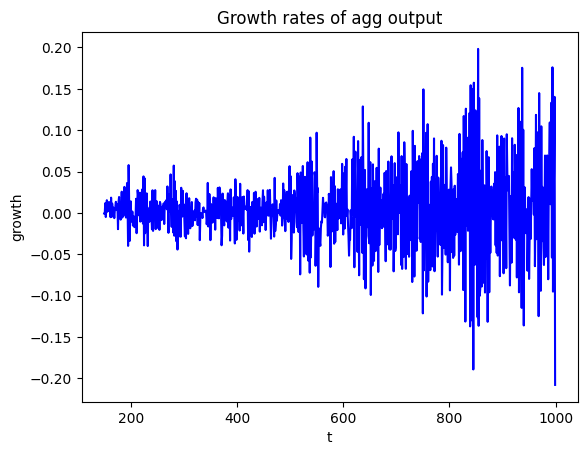

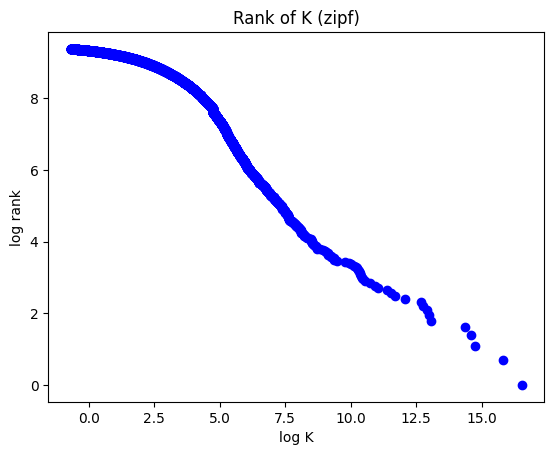

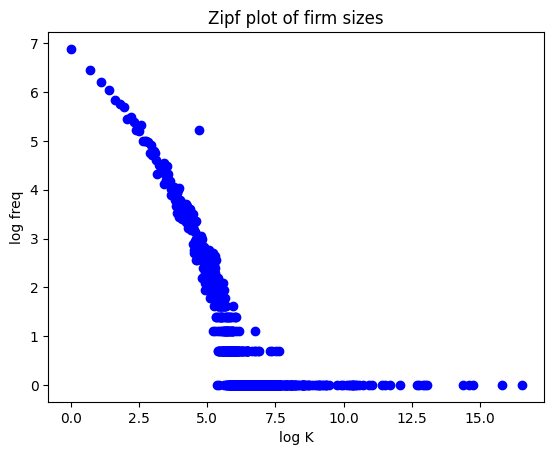

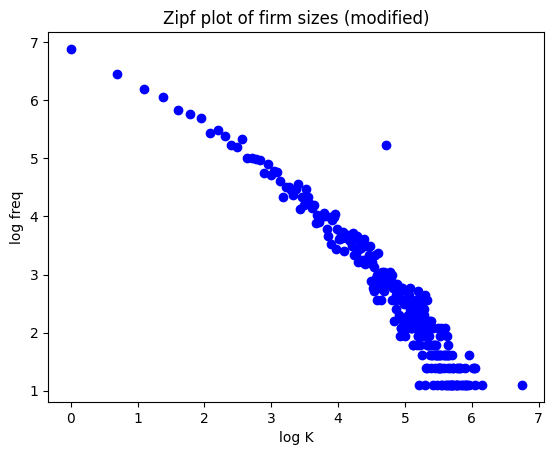

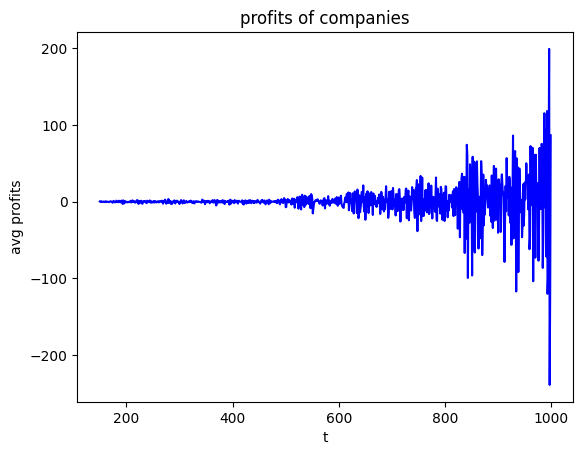

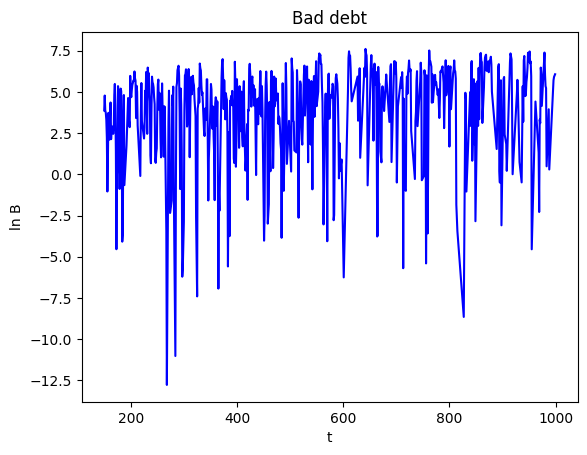

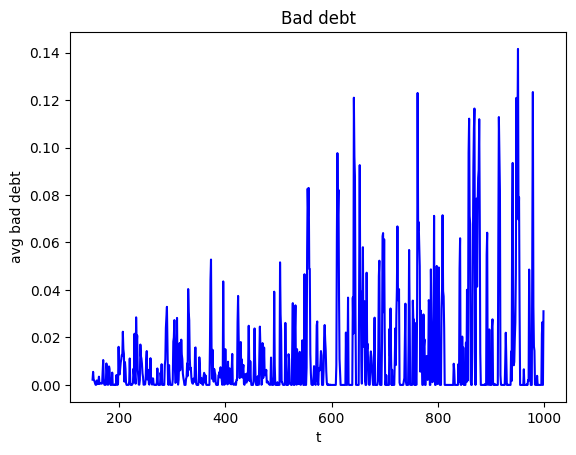

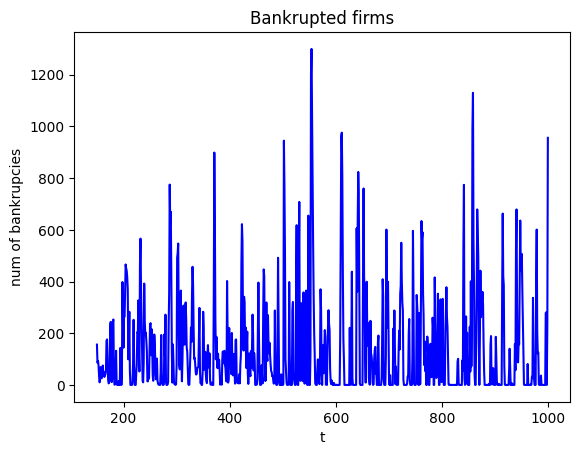

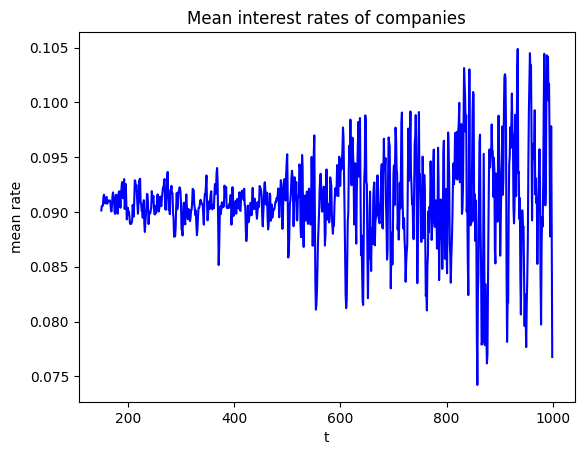

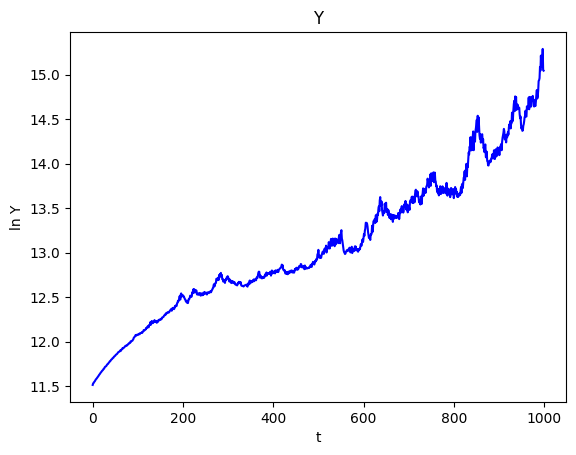

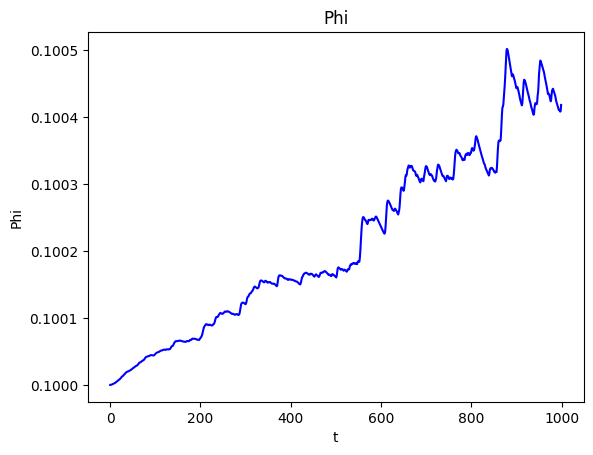

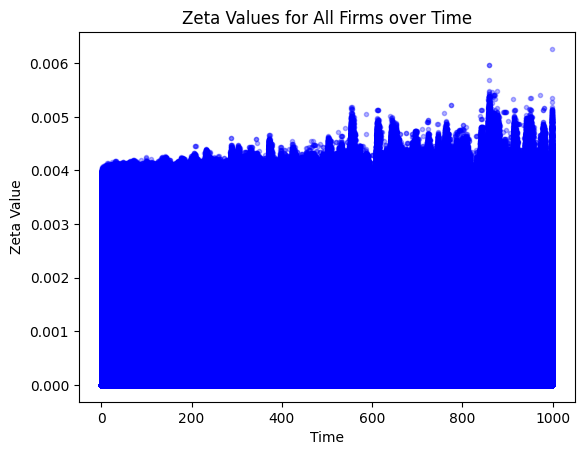

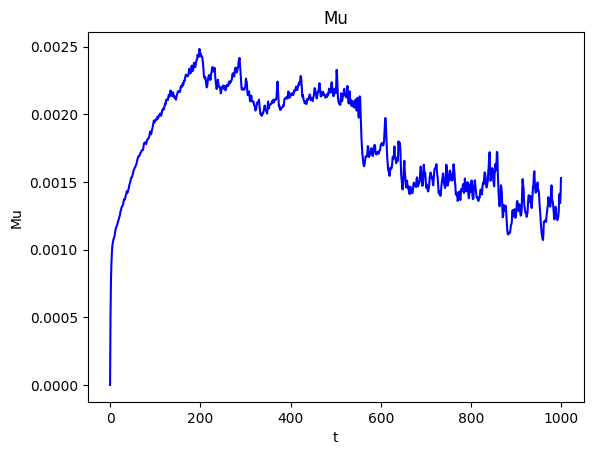

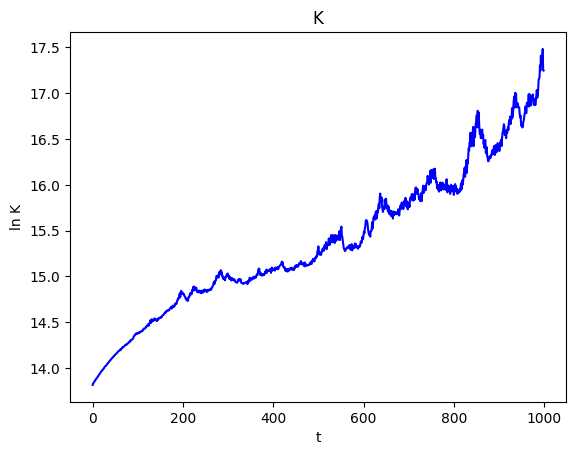

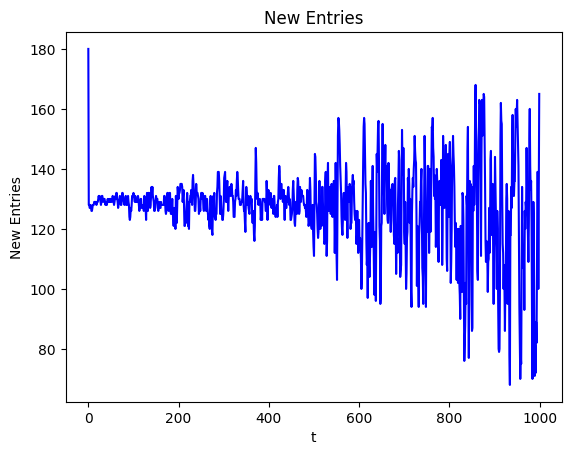

In [6]:

if __name__ == "__main__":
    if not os.path.isdir(OUTPUT_DIRECTORY):
        os.mkdir(OUTPUT_DIRECTORY)
    if not is_notebook():
        doInteractive()
    else:
        doSimulation()
        show_figures(True)

In [7]:
def calculateAverageOutput():
    avg_y = []
    for i in range(len(Statistics.firmsY)):
      avg_y.append(  Statistics.firmsY[i] / Statistics.firmsNum[i] )
    return avg_y

def calculateBankruptcyRatio():
    avg_brat= []
    for i in range(len(Statistics.bankruptcy)):
     avg_brat.append( Statistics.bankruptcy[i] / Statistics.firmsNum[i] )
    return avg_brat

def calculateAverageProductivity():
    avg_φ = []
    for i in range(len(Statistics.firmsφ)):
     avg_φ.append( Statistics.firmsφ[i] / Statistics.firmsNum[i] )
    return avg_φ

In [8]:
def calculatetotAverageProductivity():
    avg_φ = []
    for i in range(len(Statistics.firmsφ)):
        avg_φ.append(Statistics.firmsφ[i] / Statistics.firmsNum[i])

    total_avg_φ = sum(avg_φ) / len(avg_φ) if avg_φ else 0  # Maneja el caso en que avg_φ esté vacío
    return total_avg_φ
def calculatetotAverageOutput():
    avg_y = []
    for i in range(len(Statistics.firmsY)):
        avg_y.append(Statistics.firmsY[i] / Statistics.firmsNum[i])
    total_avg_y = sum(avg_y) / len(avg_y) if avg_y else 0  # Maneja el caso en que avg_y esté vacío
    return total_avg_y

def calculatetotBankruptcyRatio():
    avg_brat = []
    for i in range(len(Statistics.bankruptcy)):
        avg_brat.append(Statistics.bankruptcy[i] / Statistics.firmsNum[i])
    total_avg_brat = sum(avg_brat) / len(avg_brat) if avg_brat else 0  # Maneja el caso en que avg_brat esté vacío
    return total_avg_brat

In [9]:
calculatetotAverageProductivity()

Decimal('0.1002135104423432439344677739')

In [10]:
calculatetotAverageOutput()

Decimal('44.97895872311727111842441627')

In [11]:
calculatetotBankruptcyRatio()

0.007048607678947101

1000


In [17]:
print(Statistics.firmsNum)

[10000, 10180, 10308, 10434, 10559, 10682, 10806, 10929, 11053, 11175, 11294, 11413, 11536, 11652, 11775, 11893, 12012, 12129, 12246, 12357, 12475, 12587, 12702, 12821, 12928, 13032, 13146, 13261, 13370, 13484, 13601, 13691, 13785, 13896, 13997, 14092, 14187, 14283, 14389, 14498, 14602, 14702, 14812, 14924, 15020, 15123, 15227, 15314, 15406, 15509, 15601, 15684, 15783, 15878, 15974, 16051, 16136, 16233, 16334, 16440, 16516, 16574, 16649, 16691, 16730, 16814, 16913, 17021, 17125, 17218, 17288, 17346, 17410, 17506, 17607, 17700, 17735, 17744, 17774, 17847, 17927, 18017, 18105, 18182, 18224, 18306, 18407, 18499, 18582, 18639, 18712, 18818, 18936, 19058, 19181, 19286, 19392, 19488, 19484, 19491, 19530, 19514, 19521, 19583, 19668, 19721, 19767, 19836, 19910, 19943, 20001, 20018, 20043, 20126, 20245, 20348, 20396, 20416, 20449, 20542, 20655, 20765, 20855, 20952, 21062, 21020, 21079, 21180, 21285, 21406, 21495, 21456, 21551, 21667, 21602, 21524, 21469, 21435, 21537, 21626, 21577, 21436, 21363